## Smart water flooding analytical solution
This document is mostly based on the SPE-7660 paper by Gary Pope. I first implement the simple water flooding analytical solution and then expand it to low salinity water flooding with and without ionic adsorption.

## Mathematical model
The two phase flow equation in a 1D porous medium reads
$$\frac{\partial S_w}{\partial t}+\frac{u}{\varphi}\frac{df_w}{dS_w}\frac{\partial S_w}{\partial x} = 0 $$
The dimensionless time and space are defined as
$$t_D = \frac{ut}{\varphi L}$$ and
$$x_D = \frac{x}{L}$$
The velocity of a constant saturation front is calculated by
$$V_{S_w} = (\frac{dx}{dt})_{S_w}=\frac{u}{\varphi}\frac{df_w}{dS_w}$$
The shock front is specified by
$$\frac{f_w(S_{w,shock})-f_w(S_{w,init})}{S_{w,shock}-S_{w,init}}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
The injected water front velocity (i.e., a tracer in the injected water, or the low salinity of the injected brine) is calculated by
$$V_{c} = (\frac{dx}{dt})_{c}=\frac{u}{\varphi}\frac{f_w}{S_w}$$
an the water saturation that corresponds to the position of the salinity front is given by
$$\frac{f_w(S_{w,s})-f_w(0)}{S_{w}-0.0}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
which is the tangent line fron the point (0,0) to the $f_w-S_w$ (fractional flow) curve.
The breakthrough time (in number of pore volume) is calculated by
$$t_{D, bt} = \left(\frac{df_w}{dS_w}\right)^{-1}_{S_{w,shock}}$$
The other useful relation is the average saturation after breakthrough, which reads
$$S_{w,av} = S_{or}+\left[(1-f_w)\left(\frac{df_w}{dS_w}\right)\right]_{x=L}, \;t_D>t_{D,bt}$$ 
The recovery factor then can be calculated based on the fact that the recovery curve is linear until the breakthrough, and after breakthrough it gradually reaches a plateau. The oil recovery factor before the breakthrough is calculated by
$$R = \frac{(1-f_w(S_{w,init}))t_D}{1-S_{w,init}}, \;t_D<t_{D,bt}$$ and after breakthrough by
$$R = \frac{S_{w,init}-S_{w,av}}{1-S_{w,init}}, \; t_D>t_{D,bt}$$
Let's try the above formulation in Julia.

## Testing the codes
The `FractionalFlow.jl` package is built to solve and visualize the analytical solutions to several injection problem in the petroleum engineering, including water flooding, low salinity water flooding with and without ionic adsorption, and solvent flooding (carbonated water, DME, etc). There are several functions that are documented in the code. Here, I show by example how to define a problem, solve it, and visualize the results.

In [12]:
include("FractionalFlow.jl")
using PyPlot
FF = FractionalFlow

FractionalFlow

## Water flooding

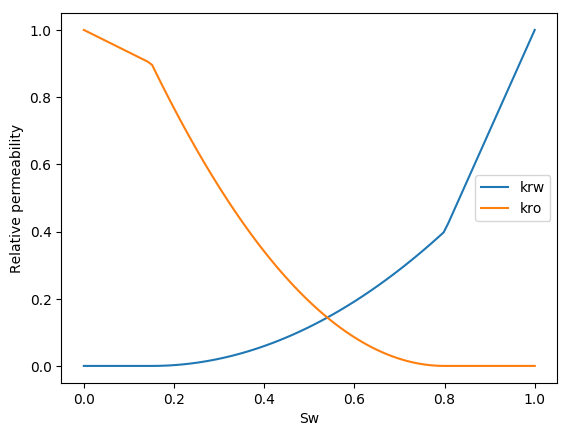

PyObject <matplotlib.legend.Legend object at 0x7fc8d0fe6ad0>

In [13]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
FF.visualize(rel_perms)

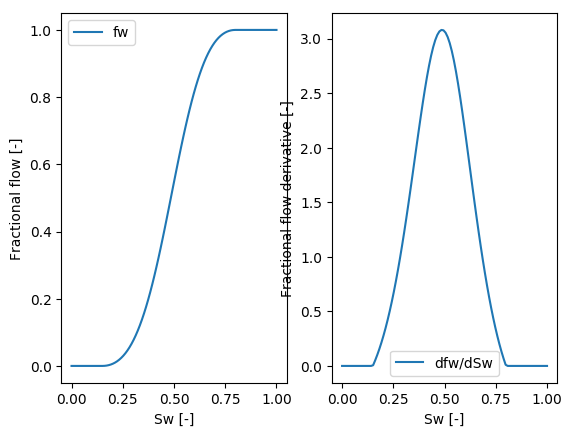

PyObject <matplotlib.legend.Legend object at 0x7fc8d13e1c90>

In [14]:
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
FF.visualize(rel_perms, fluids)

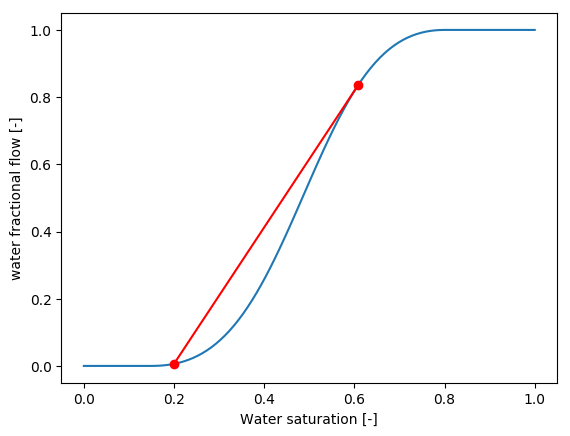

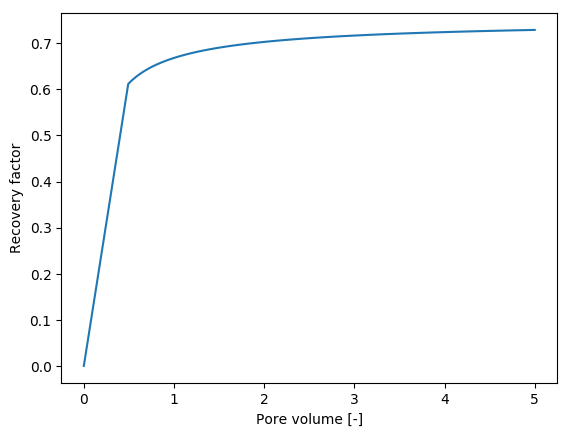

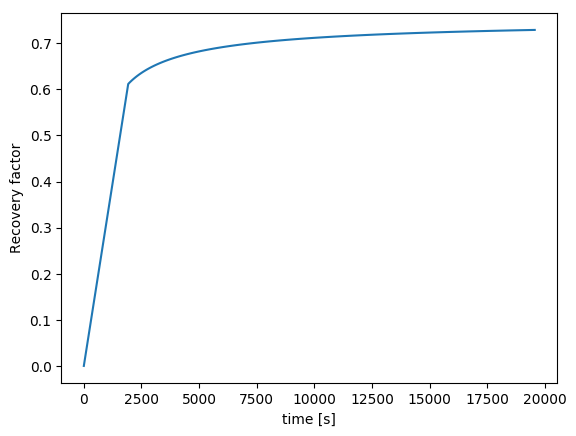

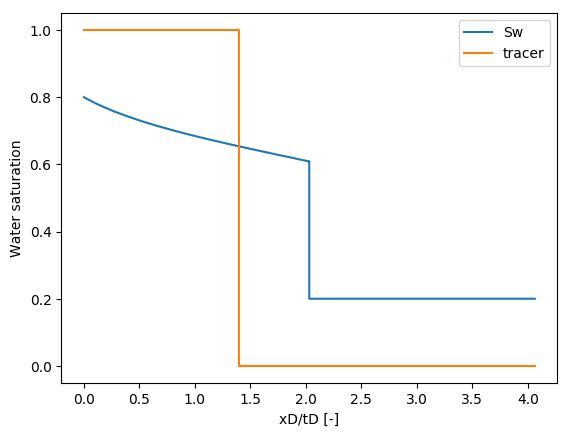

sw_shock = 0.608438467199255
breakthrough time = 0.4922812627958595


PyObject <matplotlib.legend.Legend object at 0x7fc8d10824d0>

In [15]:
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)
# plot(sw_tmp, fw.(sw_tmp), xlabel = "Sw", ylabel="fw", label="")
# plot!(sw_tmp, dfw.(sw_tmp))
# figure(1)
# plot(pv, R) 
# xlabel("PV injected")
# ylabel("Recovery factor") 
# title("Water flooding")
# figure(2)
# plot(xt, sw)
# xlabel("x/t [-]")
# ylabel("Water saturation [-]")
FF.visualize(wf_res)

## Low salinity water flooding - with/without adsorption